In [1]:
#!pip install monai

In [2]:
#!pip install -q "monai-weekly[gdown, nibabel, tqdm, itk]"

In [3]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
from PIL import Image
import torch
import numpy as np
from sklearn.metrics import classification_report
import cv2
import tensorflow as tf
import pandas as pd
import seaborn as sns

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
)
from monai.data import Dataset, DataLoader
from monai.utils import set_determinism

print_config()

MONAI version: 1.2.0
Numpy version: 1.25.2
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: d:\anaconda3\lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.19.2
Pillow version: 10.0.0
Tensorboard version: 2.10.1
gdown version: 4.7.1
TorchVision version: 0.15.2+cu117
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.0.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-depe

In [4]:
torch.__version__

'2.0.1+cu117'

In [5]:
def bordered_resize(img, scale, center=None, border_size=None, border_color=None):
    if center == None:
        center = (int(img.shape[1]), int(img.shape[0]))
    if border_size == None:
        border_size = (img.shape[1], img.shape[0])
    if border_color == None:
        border_color=(255, 255, 255)
    M = cv2.getRotationMatrix2D(center, 0, scale)
    return cv2.warpAffine(img, M, border_size, borderValue=border_color)

In [6]:
data_dir = r'C:\Users\Chirag C\vit\docs\mango\MangoLeafBD Dataset\MangoLeafBD Dataset'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x)
                for x in os.listdir(os.path.join(data_dir, class_name))]
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))
for i in range(len(image_file_list)):
    cat = cv2.imread(image_file_list[i])
    width, height = int(240), int(240)
    resized_cat = cv2.resize(cat, (width, height), interpolation = cv2.INTER_AREA,)
    #print(resized_cat.shape[1],resized_cat.shape[0])
    cv2.imwrite(image_file_list[i], resized_cat)

num_total = len(image_label_list)
image_width, image_height = Image.open(image_file_list[504]).size

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height)
print("Label names:", class_names)
print("Label counts:", [len(image_files[i]) for i in range(num_class)])

Total image count: 4000
Image dimensions: 240 x 240
Label names: ['Anthracnose', 'Bacterial Canker', 'Cutting Weevil', 'Die Back', 'Gall Midge', 'Healthy', 'Powdery Mildew', 'Sooty Mould']
Label counts: [500, 500, 500, 500, 500, 500, 500, 500]


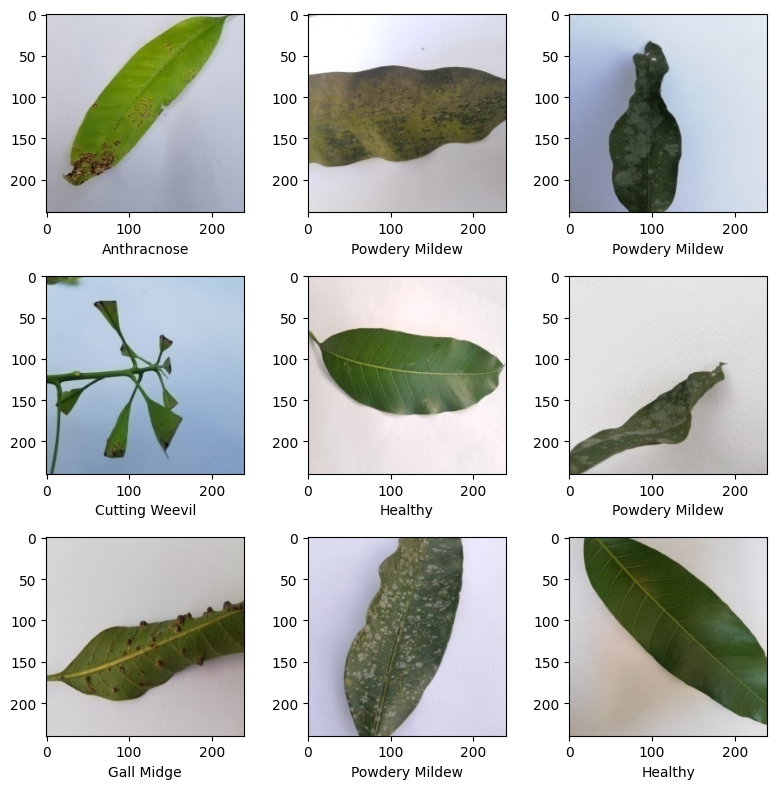

In [7]:
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = Image.open(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [8]:
valid_frac, test_frac = 0.1, 0.1
trainX, trainY = [], []
valX, valY = [], []
testX, testY = [], []

for i in range(num_total):
    rann = np.random.random()
    if rann < valid_frac:
        valX.append(image_file_list[i])
        valY.append(image_label_list[i])
    elif rann < test_frac + valid_frac:
        testX.append(image_file_list[i])
        testY.append(image_label_list[i])
    else:
        trainX.append(image_file_list[i])
        trainY.append(image_label_list[i])

print("Training count =",len(trainX),"Validation count =", len(valX), "Test count =",len(testX))

Training count = 3216 Validation count = 391 Test count = 393


In [9]:
train_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    RandRotate(range_x=15, prob=0.5, keep_size=True),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5, keep_size=True),
    ToTensor()
])

val_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    ToTensor()
])

act = Activations(softmax=True)
to_onehot = AsDiscrete(to_onehot=num_class)

In [10]:
class Mango(Dataset):

    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms
        # self.batch_size = 100

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = Mango(trainX, trainY, train_transforms)
train_loader = DataLoader(train_ds, batch_size=5, shuffle=True)

val_ds = Mango(valX, valY, val_transforms)
val_loader = DataLoader(val_ds, batch_size=5)

test_ds = Mango(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=5)

In [11]:
device = torch.device("cuda")
model = DenseNet121(
    spatial_dims=2,
    in_channels=3,
    out_channels=num_class
).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)
epoch_num = 20
val_interval = 1

In [12]:
print(model)

DenseNet121(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchN

In [13]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
auc_metric = ROCAUCMetric()
metric_values = list()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
        epoch_len = len(train_ds) // train_loader.batch_size
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(auc_result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if acc_metric > best_metric:
                best_metric = acc_metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), 'best_metric_model.pth')
                print('saved new best metric model')
            print(f"current epoch: {epoch + 1} current AUC: {auc_result:.4f}"
                  f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f}"
                  f" at epoch: {best_metric_epoch}")
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/20
1/643, train_loss: 2.2011
2/643, train_loss: 2.0651
3/643, train_loss: 2.1266
4/643, train_loss: 2.1476
5/643, train_loss: 2.2215
6/643, train_loss: 2.1939
7/643, train_loss: 2.0839
8/643, train_loss: 2.0834
9/643, train_loss: 2.0979
10/643, train_loss: 2.1547
11/643, train_loss: 2.0789
12/643, train_loss: 2.1320
13/643, train_loss: 2.0612
14/643, train_loss: 2.0036
15/643, train_loss: 1.9301
16/643, train_loss: 2.0338
17/643, train_loss: 2.1190
18/643, train_loss: 2.0666
19/643, train_loss: 2.1007
20/643, train_loss: 2.0192
21/643, train_loss: 2.1992
22/643, train_loss: 2.0299
23/643, train_loss: 1.9355
24/643, train_loss: 2.0743
25/643, train_loss: 2.1194
26/643, train_loss: 2.1860
27/643, train_loss: 1.9599
28/643, train_loss: 1.9887
29/643, train_loss: 2.0839
30/643, train_loss: 2.0629
31/643, train_loss: 2.0090
32/643, train_loss: 1.9680
33/643, train_loss: 1.9460
34/643, train_loss: 1.9844
35/643, train_loss: 2.0327
36/643, train_loss: 1.9933
37/643, train_l

In [14]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values_val = list()
auc_metric = ROCAUCMetric()
metric_values_val = list()
model.eval()
for epoch in range(epoch_num):
    print('-' * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")
    epoch_loss = 0
    step = 0
    for batch_data in val_loader:
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(val_ds) // val_loader.batch_size}, val_loss: {loss.item():.4f}")
        epoch_len = len(val_ds) // val_loader.batch_size
    epoch_loss /= step
    epoch_loss_values_val.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = val_data[0].to(device), val_data[1].to(device)
                y_pred = torch.cat([y_pred, model(val_images)], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [to_onehot(i) for i in y]
            y_pred_act = [act(i) for i in y_pred]
            auc_metric(y_pred_act, y_onehot)
            auc_result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values_val.append(auc_result)

----------
epoch 1/20
1/78, val_loss: 0.0040
2/78, val_loss: 0.0006
3/78, val_loss: 0.0011
4/78, val_loss: 0.0191
5/78, val_loss: 0.0158
6/78, val_loss: 0.0054
7/78, val_loss: 0.0006
8/78, val_loss: 0.0074
9/78, val_loss: 0.0005
10/78, val_loss: 0.0034
11/78, val_loss: 0.0039
12/78, val_loss: 0.0962
13/78, val_loss: 0.0097
14/78, val_loss: 0.0016
15/78, val_loss: 0.0350
16/78, val_loss: 0.0001
17/78, val_loss: 0.0005
18/78, val_loss: 0.0007
19/78, val_loss: 0.0001
20/78, val_loss: 0.0001
21/78, val_loss: 0.0012
22/78, val_loss: 3.6964
23/78, val_loss: 0.0016
24/78, val_loss: 0.0000
25/78, val_loss: 0.0004
26/78, val_loss: 0.0000
27/78, val_loss: 0.0002
28/78, val_loss: 0.0000
29/78, val_loss: 0.0002
30/78, val_loss: 0.0000
31/78, val_loss: 0.0002
32/78, val_loss: 0.3180
33/78, val_loss: 0.0625
34/78, val_loss: 0.0000
35/78, val_loss: 0.0000
36/78, val_loss: 0.0000
37/78, val_loss: 0.0000
38/78, val_loss: 0.0000
39/78, val_loss: 0.0000
40/78, val_loss: 0.0000
41/78, val_loss: 7.2399
42/

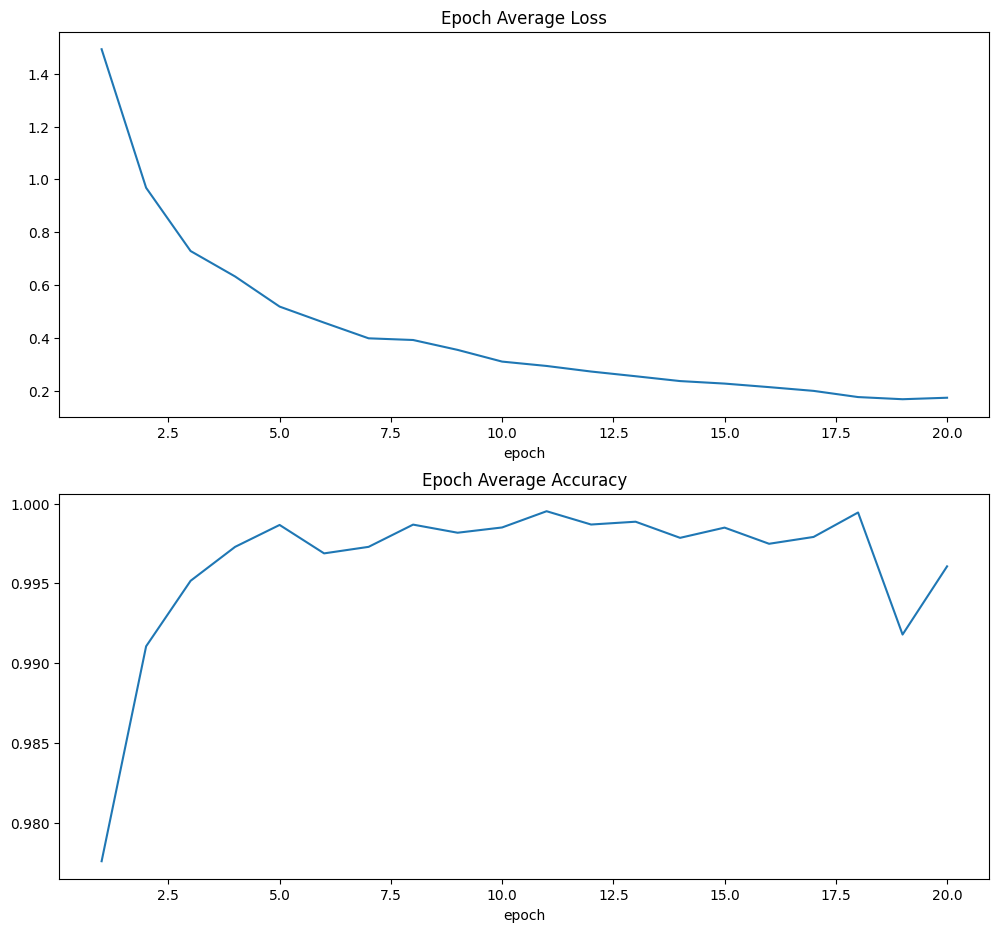

In [15]:
plt.figure('train', (12, 11))
plt.subplot(2, 1, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.subplot(2, 1, 2)
plt.title("Epoch Average Accuracy")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel('epoch')
plt.plot(x, y)
plt.show()

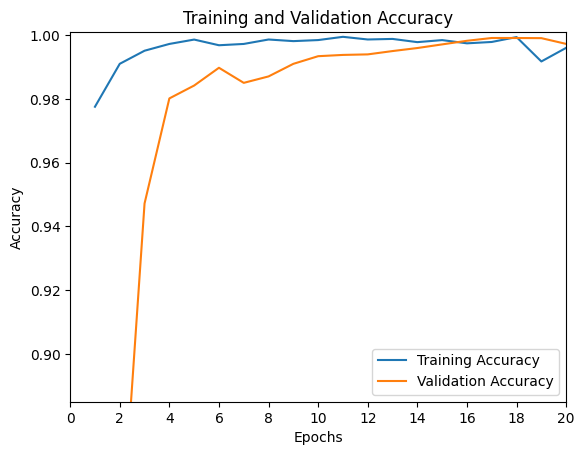

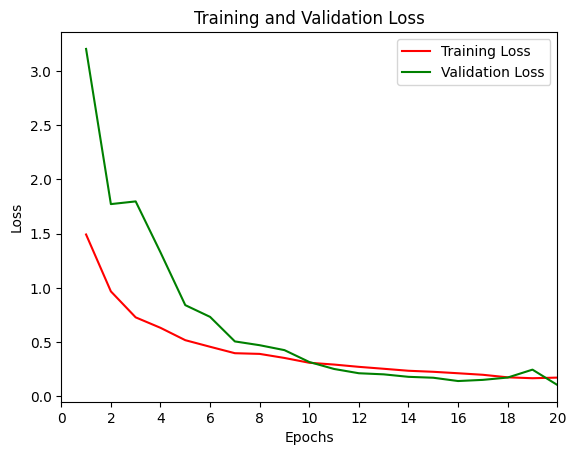

In [39]:
x1 = [i + 1 for i in range(len(epoch_loss_values))]
plt.plot(x1,metric_values, label='Training Accuracy')
plt.plot(x1,metric_values_val, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.885, 1.001])
plt.xticks(range(0, 22, 2))
plt.xlim([0, 20])

plt.show()
x1 = [i + 1 for i in range(len(epoch_loss_values))]
y1 = epoch_loss_values
y2 = epoch_loss_values_val
plt.figure()
plt.plot(x1, y1, color='r',label='Training Loss')
plt.plot(x1, y2, color='g',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, 22, 2))
plt.xlim([0, 20])
plt.legend()
plt.show()

In [17]:
model.load_state_dict(torch.load('best_metric_model.pth'))
model.eval()
y_true = list()
y_pred = list()
with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

393


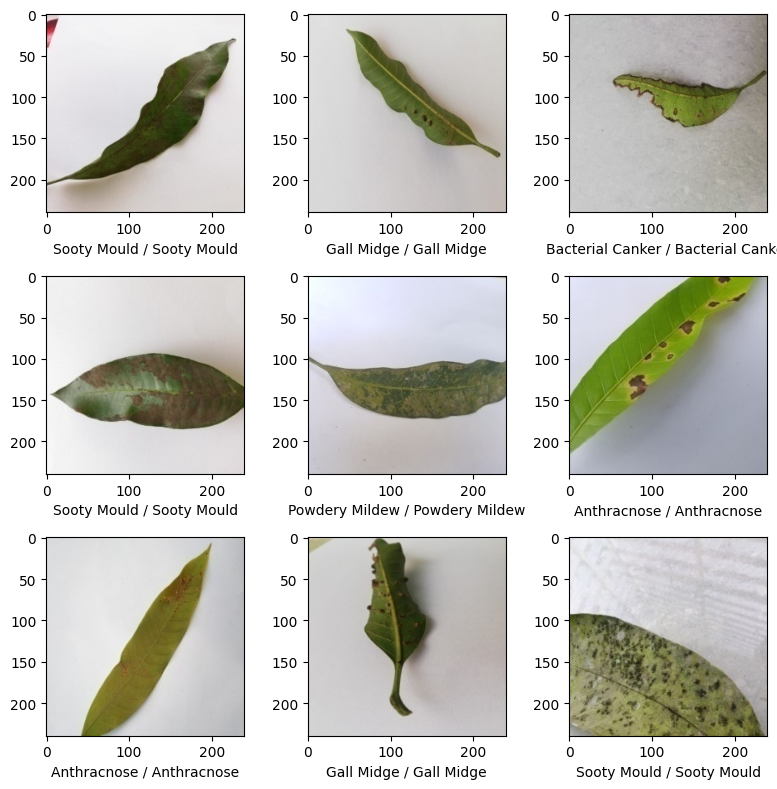

In [18]:
# print(len(test_ds))
print(len(y_pred))
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(len(y_pred), size=9)):
    im = Image.open(testX[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[testY[k]]+" / "+class_names[y_pred[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


                  precision    recall  f1-score   support

     Anthracnose     0.9091    1.0000    0.9524        40
Bacterial Canker     1.0000    0.9524    0.9756        42
  Cutting Weevil     1.0000    0.9592    0.9792        49
        Die Back     0.9600    0.9796    0.9697        49
      Gall Midge     1.0000    0.9455    0.9720        55
         Healthy     1.0000    0.9672    0.9833        61
  Powdery Mildew     0.9412    0.9412    0.9412        51
     Sooty Mould     0.8800    0.9565    0.9167        46

        accuracy                         0.9618       393
       macro avg     0.9613    0.9627    0.9612       393
    weighted avg     0.9641    0.9618    0.9623       393



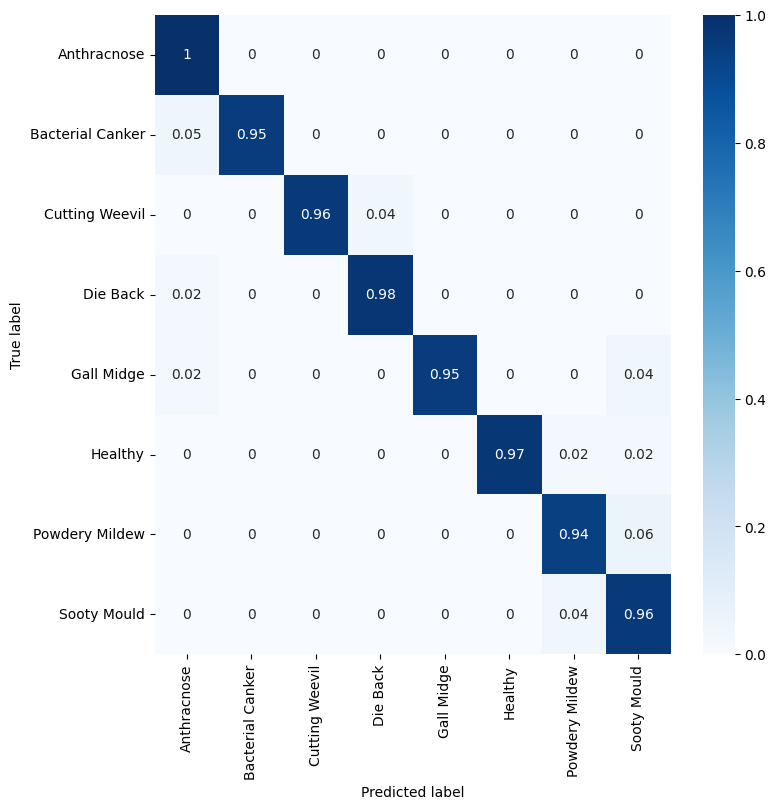

In [20]:
con_mat = tf.math.confusion_matrix(labels=y_true, predictions=y_pred).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = class_names,
                     columns = class_names)

figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [21]:
import torch.nn.functional as F
model.eval()
h = 0
res = []
test_ds = Mango(testX, testY, val_transforms)
test_loader = DataLoader(test_ds, batch_size=1)
for batch_data in test_loader:
    inputs = batch_data[0].to(device)
    outputs = model(inputs)
    y_scores = F.softmax(outputs, dim=1)
    numpy_array = y_scores[0].cpu().detach().numpy()
    numpy_array = np.around(numpy_array, decimals=1)
    res.append(numpy_array)
    h = h + 1
res = np.vstack(res)

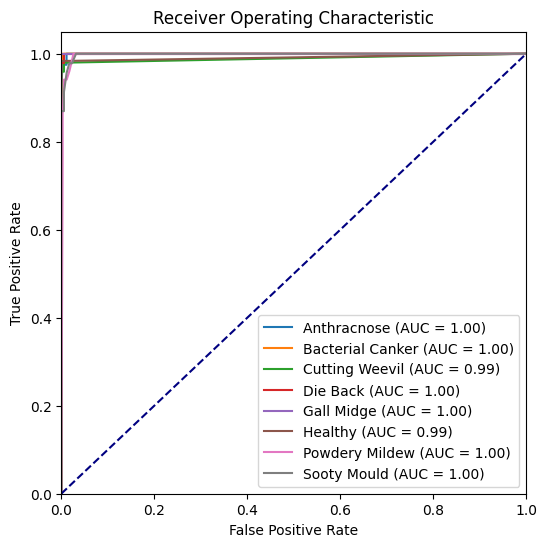

In [22]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
y_true11 = y_true
y_scores11 = res
n_classes = y_scores11.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true11, y_scores11[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(6, 6))

for i, model_name in enumerate(class_names):
    fpr[i], tpr[i], _ = roc_curve(y_true11, y_scores11[:, i], pos_label=i)
    roc_auc = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

plt.show()